## **Interpreting the Naive Bayes algorithm**

**This tutorial uses data created by Tutorial 3. If you haven't already done that one, please go through it now**

In the previous tutorial we tested 3 algorithms in our Taxonomy classification task. In this tutorial and its companion 4B we will take a closer look at the predictions from two of the algorithms. For this tutorial we will concentrate on Naive Bayes.

There are three parts to this tutorial:


1.   An introduction to probability and Bayes' Rule
2.   The inner workings of the Naive Bayes classifier
3.   Understanding the outputs of the Naive Bayes classifier

The first part is an in depth description of an important formula used in probability and statistics known as Bayes' Rule (named after the Reverend Thomas Bayes who discovered it in the 18th Century). It is an incredibly useful formula and is far more simple than it may at first appear. If you can multiply numbers with a calculator (or pen and paper) you can use the formula - but you're not going to for this tutorial. The aim is to show that there is no real mystery to the Naive Bayes algorithm.

The second part then applies your new found knowledge of Bayes' formula to look under the bonnet of Naive Bayes. This will use a simple example and we can see how the algorithm makes its decisions.

Finally, we will take the same look at the model we built in Tutorial 3. This is an opportunity to think from the TNA perspective about how we might 'show our workings' to the public if we were to use ML to label our documents. Once you've read through the explanation of Bayes's Rule it should be clear that we couldn't expect our users to learn about statistics. **How can we do it better?** At the same time, an FoI request may ask to explain why certain documents were classified as X (imagine we're not doing Taxonomy but Sensitivity instead). **Would what you see below be detailed enough to satisfy that request?**

These questions will set us up nicely for the final ML session in a few weeks.










As usual we will link up to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


And set up the folder for data files

In [0]:
data_folder = "/content/gdrive/My Drive/MLC/Session 3/Data/"

This piece of code imports the libraries that we will be using in the first part of this notebook.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sklearn      # The most common Python Machine Learning library - scikit learn
from sklearn.model_selection import train_test_split  # Used to create training and test data
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from operator import itemgetter
from nltk.stem.porter import *
import pickle
from nltk import toktok    

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


This tutorial uses datasets created by tutorial 3. 

The files are called:


*   model_NB_ngram.pck
*   ngram_tfidf.pck



**If they don't appear in the list output by the following line of code then rerun tutorial 3.**



In [4]:
os.listdir(data_folder)

['taxonomyids_and_names.txt',
 'taxonomy_descriptions.txt',
 'topN_taxonomy.csv',
 'word_tfidf.pck',
 'ngram_tfidf.pck',
 'stemmed_ngram_tfidf.pck',
 'model_DT_word.pck',
 'model_DT_ngram.pck',
 'model_SVM_ngram.pck',
 'model_NB_ngram.pck']

**Introduction to Bayes Rule**

Before reading this section you may like to watch the following video from the World Science Festival about Bayesian probability: https://www.youtube.com/watch?v=BcvLAw-JRss


First of all we need to introduce some notation:


*   X and Y are outcomes of experiments. X could be "A flipped coin landing on Heads" or "Rolling a 1 on a 6 sided die" or "Rolling an even number on the same die"
*   P(X) means the "Probability that X will happen"
*   P(X | Y) means the "Probability that X will happen when we know that Y has already happened"

*   If we multiply two probabilities it looks like this: P(X)P(Y)







**What is Bayes' Rule?**

Imagine there are two bags of sweets. In each bag the sweets are either in blue or red wrappers. In bag A, there are 20 sweets, 15 blue and 5 red. In bag B, there are 30 sweets, 5 blue and 25 red. Without you seeing which bag they chose someone hands you a red sweet. You have one extra bit of information, you've been told that the red sweets in bag A are horrid. Do you eat the sweet, or are you going to be, horror of horrors, impolite and turn down the offer?

You can already work out from the numbers above what the chances of picking a red sweet are if you have bag A or using the terminology above:
$P(Red | Bag A)$

However, what you really want to know is the reverse: "what are the chances of the sweet coming from bag A if I already know it is red?". Or in probability notation:

$P(Bag A | Red)$

This is where Bayes' Rule comes in as it is a simple (once you understand it) formula for reversing probabilities. It is named Bayes' Rule after Reverend Thomas Bayes and was published posthumously after his death in 1763 (https://en.wikipedia.org/wiki/Bayes%27_theorem).

##The Bayes formula:


$P(Hypothesis | Evidence) = \frac{P(Evidence | Hypothesis)P(Hypothesis)}{P(Evidence)}$

If this formula send you into a cold sweat, don't worry we will break it down piece by piece. The bit under the horizontal line will soon disappear, and we'll be left with multiplying two numbers together.

It is also helpful to think of this formula as a process that we use ourselves every day. We start out with some idea about the world (our hypothesis) then we are presented with some new evidence, and we update our idea based on that evidence. That's what we should do anyway!

If I start my day thinking there is a 1% chance of it raining, then I see a dark cloud on the horizon, I should update my belief in the likelihood of rain.

## Explaining the formula

Back to the formula - it is made up of four terms:


*   $P(Hypotheses)$: This is known as the 'Prior Probability' and is the probability that we would assign to our hypothesis before looking at the evidence. In the case of the sweets I have two hypotheses available to me, either the sweet came from bag A, or it came from bag B. There is no reason (we know of) why when selecting the bag of sweets a person would favour A or B. So without looking at the sweet we would say it's 50:50 whether it came from A or B. So we give each hypothesis a prior probability of 0.5. In the notation above: $P(A) = P(B) = 0.5$
*   $P(Evidence)$: For this example this is just the probability of getting a red ball irrespective of which bag it came from. In many situations this term can be tricky to calculate (although not in this one), but it turns out it can often be ignored completely. And this is one of those cases! The reason it can be ignored is that we want to compare the relative likelihood of A and B. Since this term is the same in each cancellation it cancels itself out.

*   $P(Evidence | Hypothesis)$: This is known as the likelihood term and is generally much easier to calculate than its opposite number on the other side of the equals sign (or we wouldn't need Bayes' Rule). Our evidence is that we've got a red sweet. If our hypothesis is that it came from bag A then the likelihood is the proportion of sweets in that bag which are red, 5 out of 20 (0.25). For bag B it would be 25 out of 30 (0.833).
*   $P(Hypothesis | Evidence)$: This is known as the 'Posterior Probability' (remember we started with a Prior). It gives us our updated belief in the probability of whichever hypothesis we are testing.

That's it, we only need to multiply two numbers together for each possible hypothesis. We can then compare the results to see which is the most likely scenario. You may notice in the calculations I've used an $\alpha$ instead of an equals sign. This symbol just means 'proportional to' and is used because I ditched the P(Evidence) part of the calculation.





**A worked example**

Let's run through the calculations and then we can move on to applying what you've learned to text classification:

P(A | Red) $\alpha$ P(Red | A) * P(A) = 0.25 * 0.5 = 0.125

P(B | Red) $\alpha$ P(Red | B) * P(B) = 0.833 * 0.5 = 0.4165

If you divide the 2nd number by the 1st, you find that we are over 3 times more confident that the sweet came from bag B - so I eat the sweet and avoid the awkward situation of mumbling something about 'saving it for later'.

It's worth pointing out that these aren't technically probabilities. If they were they would add to 1. We would need to use the P(evidence) term to get proper probabilities, but they are good enough for weighing up which is the most likely scenario.

**My friend the prankster**

Now, what happens if I know that my friend who passed me the sweet is actually an evil prankster. I'm now 90% sure they have purposefully chosen bag A because they know it has the horrible sweet (their poker face prevents them giving away the answer). In this case we can change our calculation by using a different prior probability for each bag. Now P(A) is 0.9 (90%) which leaves P(B) as 0.1 (the remaining 10%). Here are the new calculations:

P(A | Red) $\alpha$ P(Red | A) * P(A) = 0.25 * 0.9 = 0.225

P(B | Red) $\alpha$ P(Red | B) * P(B) = 0.833 * 0.1 = 0.0833

I'm now nearly 3 times more confident that this is from bag A and therefore one of the horrid sweets. "Oh no, please I insist, you have it", I say to my friend.

Bayes' Rule has been controversial in the mathematical world over the centuries but it is now heavily used in all sorts of areas. The ability to combine our own subjective (and expert) knowledge of the world, through the prior, with hard statistical evidence, to come up with a number that would be too hard to measure statistically makes it a very powerful tool in the data scientist's toolkit.

**Applying Bayes' Rule to text classification**

In the previous tutorial you used the Naive Bayes classifier as one of the three algorithms. I will explain the Naive part shortly but using what we've learned above we can already begin to see how this classifier might work.

Given a record description (the evidence) we want to predict the taxonomy class. There are 10 possible classes, so I have 10 hypotheses to test. The prior probability for any chosen class (e.g Medals) is the proportion of records in my training data which are assigned that class. We already know this from summarising records in tutorial 1.

How do we calculate likelihoods? Well we know we have, say, 5000 features in our training data which we selected in tutorial 2. For each of the 10 classes we can count all of the words (or ngrams) in descriptions from that class, then count how many times each individual word (or ngram) occurs. We can then say something like "given category 'Medals' the probability of the word 'medal' occurring in the description is 0.005" (out of every 1000 words, 5 of them are 'medal').

Then when we encounter the word 'medal' in a description we can look up the probability of it appearing in that class and plug it into the formula above.

Now a description obviously contains multiple words, so what is the probability of 'this is a medal card'. If we assume that the probability of individual words is unaffected by those around it, then we can multiply probabilities together. We know from our own knowledge of language that saying that words are all independent of each other is a big assumption (I'm more likely to talk about 'grey rhinos' and 'green apples' than 'green rhinos' and 'grey apples') but it turns out that the model still works pretty well. This is where the Naive part comes from, it uses a very Naive assumption about language. As the statistician George Box said, **"all models are wrong, some are useful"**. Naive Bayes is one of the useful ones.

We will now try a toy example before examining the model we built in tutorial 3.


**The inner workings of the Naive Bayes classifier**

We will start by creating some data to work with. Here are six sentences and each has been classified as type 'C' or type 'D'.

In [5]:
data = pd.DataFrame({'id':[1,2,3,4,5,6], 
                     'sentence': ['the cat sat on the mat','the little dog laughed','the cat was little','the cat purred','the dog barked','the cat laughed at the dog'],
                     'classification':['C','D','C','C','D','C']})
data

,id,sentence,classification
0,1,the cat sat on the mat,C
1,2,the little dog laughed,D
2,3,the cat was little,C
3,4,the cat purred,C
4,5,the dog barked,D
5,6,the cat laughed at the dog,C


For this example we will use the CountVectorizer instead of TF-IDF, as the outputs are more intuitive. This vectoriser will count occurrences of each word in a sentence. We will then use the Naive Bayes algorithm to learn a predictive model, although we're not aiming to use this model. The aim of this example is to look at the numbers that are derived from the data and see them being used in the calculations.

In [6]:
vectoriser = CountVectorizer()
vectoriser.fit_transform(data.sentence)
model = MultinomialNB()
model.fit(vectoriser.transform(data.sentence), data.classification)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In the Bayes formula we started with a prior probability so let's find those for our data. Running the following code should show you that the probality of class C is 0.666667. This makes sense as 4 out of 6 records were class C, and 4 divided by 6 is 0.666667

So before we see a sentence our prior knowledge suggests that it is more likely (twice as likely in fact) to be a 'C' than a 'D'.

In [7]:
pd.DataFrame(zip(model.classes_,np.exp(model.class_log_prior_)), columns = ["Class", "Probability"])

,Class,Probability
0,C,0.666667
1,D,0.333333


Now let's have a look at word frequencies. The following code outputs the proportions of each word in each class.

For example, 16.1% of words in class 'C' sentences are 'cat', and 15.7% of class 'D' words are 'dog' (wonder what 'C' and 'D' could stand for?).

Look at the word percentages for each list and compare them to the sentences in the table above. **Do you notice anything odd?** (HINT: look at the percentages for 'barked' and 'purred')

Note: If you don't know (or care) about logarithms then carry on to the next section. If you're still reading...

In the following code there seems to be quite a bit of calculating to get the percentages ("(np.exp(model.feature_log_prob_)[c]*1000).astype(int)/1000)"). The reason for this is that instead of storing word probabilities, the algorithm stores the logarithm of the probabilities. The logarithm is used for computational reasons. One reason is that if you use logs then you can add values instead of multiplying, which is a more efficient calculation. Secondly, if you are multiplying lots of small probabilities you can end up with a underflow problem and find your calculations reducing to zero which is a disaster. Using logs avoids this problem.

In [8]:
for c in range(len(model.classes_)):
    print("Word distribution for class:", model.classes_[c])
    for w in [x for x in zip(vectoriser.get_feature_names(),(np.exp(model.feature_log_prob_)[c]*1000).astype(int)/1000)]:
        print("\t",w[0].ljust(10),":\t",w[1]*100,"%")

Word distribution for class: C
	 at         :	 6.4 %
	 barked     :	 3.2 %
	 cat        :	 16.1 %
	 dog        :	 6.4 %
	 laughed    :	 6.4 %
	 little     :	 6.4 %
	 mat        :	 6.4 %
	 on         :	 6.4 %
	 purred     :	 6.4 %
	 sat        :	 6.4 %
	 the        :	 22.5 %
	 was        :	 6.4 %
Word distribution for class: D
	 at         :	 5.2 %
	 barked     :	 10.5 %
	 cat        :	 5.2 %
	 dog        :	 15.7 %
	 laughed    :	 10.5 %
	 little     :	 10.5 %
	 mat        :	 5.2 %
	 on         :	 5.2 %
	 purred     :	 5.2 %
	 sat        :	 5.2 %
	 the        :	 15.7 %
	 was        :	 5.2 %


You may have noticed that 'purred' never appears in the two 'D' sentences, yet it accounts for 5.2% of the words in class 'D'. How is this possible?

If we think back to the Bayes calculation we are multiplying probabilities. Imagine if we encountered the sentence 'dog dog dog purred'. If the probability of 'purred' for class 'D' was zero, then we would be multiplying P('dog' | 'D') three times and then multiplying by zero. So the answer is zero! Since both 'purred' and 'dog' appear in a class 'C' sentence, our classifier will decide this is definitely a 'cat' sentence despite 'dog' appearing three times.

To get around this problem the Bayes classifier adds one to all of the word counts so that no value is zero. 

We will now try and run through the calculation for a simple sentence, "the cat".

We have two hypotheses: 'C' or 'D'. Let's start with 'C'

Our prior P('C') from above is 0.6667. P('cat' | 'C') and P('the' | 'C') can be looked up in the table we just produced. They are 0.161 and 0.225 respectively.

So P('C' | 'the cat') = 0.6667 * 0.161 * 0.225 = 0.02415

Similarly,

P('D' | 'the cat') = 0.3333 * 0.052 * 0.157 = 0.0027

The first value is nearly 10 times bigger, so we're overwhelmingly in favour of class 'C'.

Remember earlier we said that these weren't technically probabilities? To be probabilities they would need to add up to one. We can easily do this, by adding them together (0.02415 + 0.0027 = 0.02685) and then dividing the two values by this total. Now we have:


*   P('C' | 'the cat') = 0.02415 / 0.02685 = 0.899
*   P('D' | 'the cat') = 0.0027  / 0.02685 = 0.1005

Give or take rounding errors this adds up to 1.

Now let's compare this with the output from the Bayes classifier we built...


In [9]:
pd.DataFrame(model.predict_proba(vectoriser.transform(["the cat"])), columns = ['C','D'])

,C,D
0,0.897595,0.102405


And we agree with the model's answer. Phew!

Let's try another sentence using the same vocabulary (if you introduce new words they'll be ignored by the vectoriser and therefore be left out of the calculations). Even though 'little' and 'barked' are more 'D' words, we still find that the model is twice as confident that this is a 'C' sentence than 'D'. This is partly because 'cat' is much more of a 'C' word but also because our prior probability of 'C' is double that of 'D'. So some major dogness would be needed to outweigh that. 

Feel free to experiment with your own sentences to see what happens:



In [10]:
my_sentence = "the little cat barked"
pd.DataFrame(model.predict_proba(vectoriser.transform([my_sentence])), columns = ['C','D'])

,C,D
0,0.622117,0.377883


##**Exploring the Naive Bayes taxonomy model**

Finally we are ready to explore the NB model you created in tutorial 3. There are three parts to this:

*   Look at right and wrong examples
*   Look at how confident the model is
*   Look at how we might show our workings

We will start by loading the model we created in Tutorial 3 and the Discovery data we've been using all along.

**Note:** Throughout this part of the tutorial I may refer to results or numbers that differ to the ones you get when you run the code. This is because everyone is using a different random sample of training data and so some word counts, and therefore the probabilities in the model, may vary. Hopefully your results will be fairly similar though.

*******************************************************************************

**Recommendation: copy the list of Taxonomy and Categories (below) into Notepad, or similar, so you have it handy for the rest of the tutorial. It will help interpret results which output the codes.**

(If you've worked in Cataloguing or CEE for several years this may not be necessary)

In [11]:
nb_model = pickle.load(open(data_folder + 'model_NB_ngram.pck', 'rb'))
vectoriser = pickle.load(open(data_folder + 'ngram_tfidf.pck', 'rb'))
descriptions = pd.read_csv(data_folder + 'topN_taxonomy.csv',
                           delimiter="|", header=0, lineterminator='\n')
descriptions = descriptions.drop(descriptions.columns[[0]], axis=1) 
descriptions.columns = ["IAID","TAXID","Description"]

taxonomy = pd.read_csv(data_folder + 'taxonomyids_and_names.txt',
                           delimiter="|", header=None, lineterminator='\n')
taxonomy.columns = ["TAXID","TaxonomyCategory"]

topN = pd.merge(descriptions, taxonomy, how = 'inner').groupby(['TAXID', 'TaxonomyCategory']).size().reset_index(name='Count').sort_values('Count', ascending=False)
topN

,TAXID,TaxonomyCategory,Count
5,C10092,Army,17113
1,C10005,"Art, architecture and design",14114
3,C10060,Medals,12049
4,C10072,Navy,10691
0,C10002,Air Force,6682
2,C10058,Maps and plans,5805
9,C10131,Europe and Russia,4790
8,C10127,Indian Subcontinent,3275
6,C10106,Taxation,3144
7,C10108,Trade and commerce,2891


We will start by applying the model to our data and making predictions. The top 5 all look good but in the next step we will identify some examples of good and bad predictions.

In [12]:
pd.set_option('display.max_colwidth', 130)
vec_descriptions = vectoriser.transform(descriptions.Description)
predictions = nb_model.predict(vec_descriptions.toarray())
descriptions['predicted'] = predictions
descriptions.head(5)

,IAID,TAXID,Description,predicted
0,C13122444,C10005,"Registered design number: 381468. Proprietor: The Strines Printing Company. Address: 19 George Street, Manchester, Lancashi...",C10005
1,C13089234,C10005,"Registered design number: 196086. Proprietor: James Black and Company. Address: 23 Royal Exchange Square, Glasgow, Scotland...",C10005
2,C13195333,C10092,"Statements of Service, Royal Artillery 10 Battalion Numbers 1 to 477. This entry appears on opening 381; this number is impr...",C10092
3,C12894455,C10005,"Registered design number: 47236. Proprietor: R Dalglish, Falconer and Company. Address: Lennox Mill, Lennox Town, North Bri...",C10005
4,C12896588,C10005,"Registered design number: 49663. Proprietor: R Dalglish, Falconer and Company. Address: Lennox Mill, Lennox Town, North Bri...",C10005


The following are a sample of 20 correct predictions. For this example I have used a list of IAIDs (unique identifiers for Discovery records) so that we're all seeing the same records. If you wish to try out with a different list just remove the '#' from the front of the middle line (in green) and run the code.

We will look at a couple of examples in more detail next.

In [13]:
right_list = ['C12967252', 'C12636117', 'C13120311', 'C12900469', 'C2900655', 'C13327308', 'C13096941', 'D7453690', 'C15544098', 'C3861417',
              'C16973497', 'C11595872', 'C16997630', 'C12974953', 'C1062968', 'D8412524',  'C12953395', 'D7455711', 'C1081822',  'C16421625']

#right_list = [x for x in descriptions[descriptions.TAXID == descriptions.predicted].sample(20)['IAID']]

descriptions[descriptions.IAID.isin(right_list)]

,IAID,TAXID,Description,predicted
2227,C12900469,C10005,"Registered design number: 53263. Proprietor: Charles Swaisland. Address: Crayford, Kent. Subject: Prints. Class 10: print...",C10005
7197,D7453690,C10002,CR ShortSergeant4901 September 1942,C10002
7481,C12636117,C10131,Design number: 213142. Name: Gros Roman Marozeau. Address: Wesserling Haut Rhin France.,C10131
15268,C1081822,C10092,Lieutenant Frank Dale CHADWICK The Duke of Wellington's (West Riding Regiment).,C10092
19730,C11595872,C10058,Sheet Number SP 04 NE on Ordnance Survey (OS) based mapping dated 1992,C10058
24059,C16973497,C10092,Folio(s): 475-476. Name: William B Holmes. Rank: Private. Unit/Battalion/Regiment: 9 The Leicestershire Regiment. Servic...,C10092
24166,C15544098,C10106,Certificate of residence showing Nathaniel Legg (or the variant surname: Legge) to be liable for taxation in Wiltshire. (De...,C10106
25087,C13096941,C10005,"Registered design number: 329054. Proprietor: F W Ashton and Company. Address: 45 Portland Street, Manchester, Lancashire. ...",C10005
27202,C16997630,C10002,Pilot Officer N P Warden: missing believed killed; aircraft failed to return from operational flight over the English Channel...,C10002
39844,C12967252,C10005,"Registered design number: 151008. Proprietor: The Strines Printing Company. Address: 19 George Street, Manchester, Lancashi...",C10005


In the following example we will print out a description that was correctly classified by the model. We will then print out prediction probabilities for each class. These are the numbers that we would get if we followed our Bayes' Rule calculations that we learned about earlier (with one slight change because we would use the TF-IDF score too, so don't try this at home).

My model has classified this as 'C10131' with 85% confidence, hopefully yours is similar but don't worry if it isn't. The rest of the scores are very low, 1 or 2%. They don't quite add up to 100% because of rounding errors in the calculations in the code below but they're close enough.

**Think from the perspective of the Archive. Would you be happy to label this specific example as 'C10131' in Discovery, or do you feel the user needs to know about the confidence score?**

In [21]:
IAID = 'C2900655'
sentence = descriptions[descriptions.IAID == IAID].Description.to_string(index = False)
vec = vectoriser.transform([sentence]).toarray()
prediction = nb_model.predict(vec)
print("Text " + '"' + sentence + '"', "predicted as: " + str(prediction[0]))
print("Probabilities of each class are:")
pd.DataFrame((nb_model.predict_proba(vec) * 100).astype(int) / 100, columns = nb_model.classes_)


Text " Transmission of messages to and from Norway. Code NN file 1991" predicted as: C10131
Probabilities of each class are:


,C10002,C10005,C10058,C10060,C10072,C10092,C10106,C10108,C10127,C10131
0,0.01,0.0,0.02,0.01,0.02,0.0,0.01,0.02,0.0,0.85


In the next example we see an even more definitive classification with a confidence of 99%. We will revisit this example again later as it reveals a 'gotcha' in our training process.

In [15]:
IAID = 'C15544098'
sentence = descriptions[descriptions.IAID == IAID].Description.to_string(index = False)
vec = vectoriser.transform([sentence])
prediction = nb_model.predict(vec)
print("Text " + '"' + sentence + '"', "predicted as: " + str(prediction[0]))
print("")
print("Probabilities of each class are:")
pd.DataFrame((nb_model.predict_proba(vec) * 100).astype(int) / 100, columns = nb_model.classes_)


Text "  Certificate of residence showing Nathaniel  Legg (or the variant surname: Legge) to be liable for taxation in Wiltshire.  (De..." predicted as: C10106

Probabilities of each class are:


,C10002,C10005,C10058,C10060,C10072,C10092,C10106,C10108,C10127,C10131
0,0.0,0.0,0.0,0.0,0.0,0.0,0.99,0.0,0.0,0.0


Now we will look at some incorrect predictions.

In [16]:
wrong_list = ['C8902440', 'D8006774', 'D7578831', 'D8028690', 'C8192385', 'D7963041', 'D8411035', 'D8045600', 'D6687835', 'C2542874',
              'D8047059', 'D8019265', 'D8041161', 'D4319271', 'D4361597', 'D8024716', 'D7981740', 'C4093217', 'D8005700', 'D8009277']
              
#wrong_list = [x for x in descriptions[descriptions.TAXID != descriptions.predicted].sample(20)['IAID']]

descriptions[descriptions.IAID.isin(wrong_list)]

,IAID,TAXID,Description,predicted
10418,D8005700,C10060,BWDrewsonFrank ReginaldBirkenhead1896,C10092
10636,D8019265,C10060,"BWGoddenCharles EdwardShorne, Kent1865",C10092
11306,D8024716,C10060,"BWHamonAlfred CharlesSt Heliers, Jersey1901",C10092
11815,D8009277,C10060,BWErrickerSidney EdwinSurrey1902,C10092
12098,D8006774,C10060,BWEarleyFrancis JosephSouthampton1860,C10092
14205,D8028690,C10060,BWHemburyCharlesBristol1885,C10092
31684,D4361597,C10060,SRogerson MBEJohn LambS2130504 June 1883,C10072
32903,D4319271,C10060,SMotaletAboul1015928,C10092
57111,D7981740,C10060,"BWBradnockCharles EdwardEgremont, Cheshire1897",C10092
59092,D7578831,C10072,RNDruryCharles CarterAdmiral1756-1917,C10060


The first example highlights a data quality problem which was missed in Tutorial 1 but is handy for making a point.

Due to concatenation of the words in this description (this is probably due to the way new line characters have been handled in the data preparation - oops!), none of the words in this description are in our feature list (the TF-IDF vectoriser created in Tutorial 2). This means Naive Bayes has zero evidence to go on.

Run the following code to see the results.

In [17]:
IAID = 'D8045600'
sentence = descriptions[descriptions.IAID == IAID].Description.to_string(index = False)
vec = vectoriser.transform([sentence])
prediction = nb_model.predict(vec)
print("Text " + '"' + sentence + '"')
print("")
print("Predicted category: " + str(prediction[0]))
print("Correct category:  " + descriptions[descriptions.IAID == IAID].TAXID.to_string(index = False))
print("")
print("Probabilities of each class are:")
pd.DataFrame((nb_model.predict_proba(vec) * 100).astype(int) / 100, columns = nb_model.classes_)



Text " BWKnowlesEustace OliverAldeburgh1892"

Predicted category: C10092
Correct category:   C10060

Probabilities of each class are:


,C10002,C10005,C10058,C10060,C10072,C10092,C10106,C10108,C10127,C10131
0,0.08,0.17,0.07,0.14,0.13,0.21,0.03,0.03,0.04,0.05


If we now look at the prior probabilities (otherwise known as the distribution of classes in the data) we see identical numbers.

The algorithm has started with its prior opinion and received no evidence to change its mind, so none of the values are updated.

In [18]:
priors = pd.DataFrame(columns=nb_model.classes_)
priors.loc[1] = (np.exp(nb_model.class_log_prior_) * 100).astype(int) / 100
priors

,C10002,C10005,C10058,C10060,C10072,C10092,C10106,C10108,C10127,C10131
1,0.08,0.17,0.07,0.14,0.13,0.21,0.03,0.03,0.04,0.05


The next example shows a prediction which is wrong but the algorithm wasn't super confident about it.

My model predicts category 'C10092' with 54% confidence, which is wrong. However, it predicts the correct category, 'C10131', with 32% confidence.

We can delve into this example a little further later to try and understand this uncertainty. But for now reconsider the question we asked above...

**Think from the perspective of the Archive. Would you be happy to label this specific example as 'C10131' in Discovery, or do you feel the user needs to know about the confidence score?**

In [19]:
IAID = 'C8902440'
sentence = descriptions[descriptions.IAID == IAID].Description.to_string(index = False)
vec = vectoriser.transform([sentence])
prediction = nb_model.predict(vec)
print("Text " + '"' + sentence + '"')
print("")
print("Predicted category: " + str(prediction[0]))
print("Correct category:  " + descriptions[descriptions.IAID == IAID].TAXID.to_string(index = False))
print("")
print("Probabilities of each class are:")
pd.DataFrame((nb_model.predict_proba(vec) * 100).astype(int) / 100, columns = nb_model.classes_)



Text "  NICOLAS BILLEY alias NICOLAS BILLIEY Born DAMPIERE LES DOL, France Served in Chasseurs Britanniques; Foreign Invalids Dischar..."

Predicted category: C10092
Correct category:   C10131

Probabilities of each class are:


,C10002,C10005,C10058,C10060,C10072,C10092,C10106,C10108,C10127,C10131
0,0.01,0.0,0.0,0.03,0.04,0.54,0.0,0.01,0.01,0.32


# **Which words matter?**

In the sections above we looked at the output of the algorithm for specific examples. This told us how confident the algorithm was in its classification and how it compared to other classifications. In the last example it was only 54% confident in the given answer, and 32% in the next alternative.

If we want to delve further into the result we can look at the individual word/ngram probabilities. This is easily done by first of all identifying the words in the description which are included in the 'vectoriser', i.e. the top 5000 (or whatever value was used in Tutorial 3) words/ngrams in the training data.

The code below will generate a graph of the tf-idf scores for each word/ngram in the description (which is extracted by the vectoriser). The tf-idf weightings are used in the calculation to weight the influence of each word. So we see that "les" has the highest value, and "in" has the lowest. This is because "les" is relatively unusual in the entire training corpus, while "in" is a very common word.

It turns out in this example the weightings don't matter so much as the relative probabilities across the classes are rather distinct. The next set of graphs will demonstrate this.

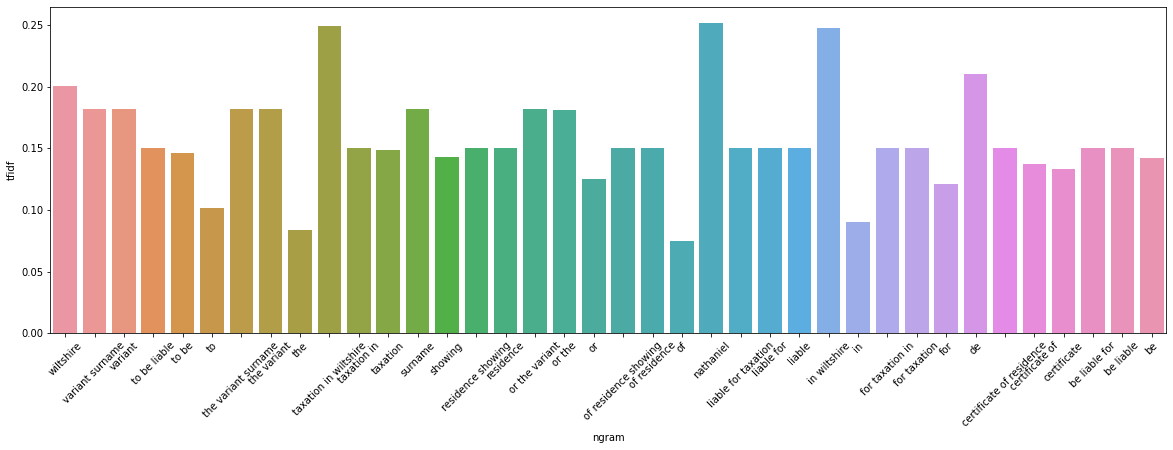

In [0]:
features = vec.nonzero()
feature_names = np.take(vectoriser.get_feature_names(), features[1])
feature_values = vec[features].T
tfidf_data = pd.DataFrame([(x[0],x[1].item()) for x in zip(feature_names, feature_values)], columns = ['ngram','tfidf'])
plt.figure(figsize=(20,6))
sns.barplot(data = tfidf_data, x = 'ngram', y = 'tfidf')
plt.xticks(rotation = 45, size = 10)
plt.show()

The next piece of code outputs a graph for each word/ngram feature. Each graph shows the probability of that word appearing in a description for each class of record. The graph for "in" for example shows that it appears across all of the classes and that it is relatively more common in 2 classes in particular ("C10092" and "C10106"). This suggests descriptions in those classes follow a fixed format.

If turn our attention to the graphs for "served in", "served" and "born", we see that they are fairly common in descriptions of class "C10092" but rare in all other classes. Again this suggests a common format for records of that class.

The graph for "france" suggests that only records of "C10131" contain the word France as there isn't a hint of a bar for the other classes. We will come back to this later.


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


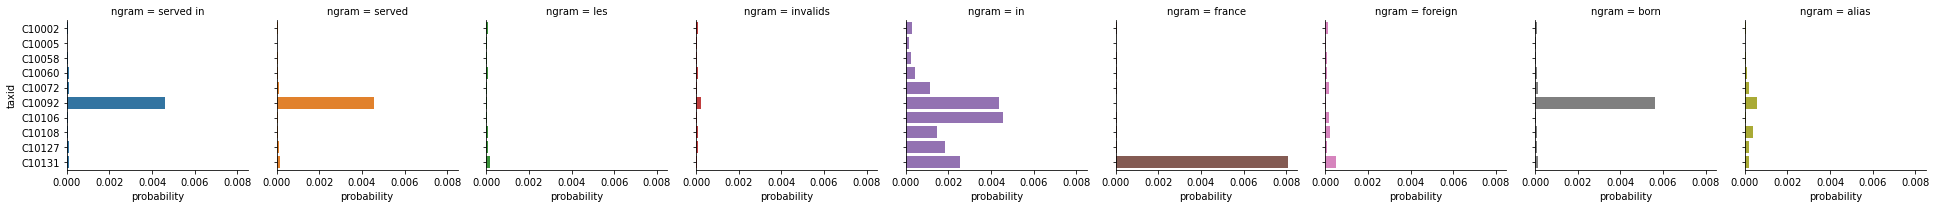

In [0]:
feature_probs = np.exp(nb_model.feature_log_prob_[:,features[1]])
feature_probs.shape
feature_probs = pd.DataFrame(feature_probs.T, columns = nb_model.classes_)
feature_probs['ngram'] = feature_names
feature_probs
feature_probs = feature_probs.melt(['ngram'], var_name='taxid',value_name='probability')
g = sns.FacetGrid(feature_probs, col = 'ngram', hue = 'ngram')
g.map(sns.barplot, 'probability', 'taxid', hue_order = feature_names)

We now have three bits of information which help explain the classification of 54% in favour of class "C10092" and 32% in favour of class "C10131" (the correct value).



1.   The prior probability of "C10092" is 21% vs. 5% for "C10131" (see table of prior probabilities above)
2.   The word "france" is weighted slightly higher than the words "served in", "served" and "born" in the tf-idf scores. But it is 3 against 1
3.   "served in", "served" and "born" provide strong evidence in favour of "C10092" but "france" provides even stronger evidence that it is a "C10131".

If we think that our prior probability for "C10092" was four times that of "C10131" (21% to 5%), and our posterior is much closer (54% to 32%) it shows that the influence of the word "france" on its own has outweighed the influence of the other three words - just not quite enough.

After the next example we will look at this more closely.



Let's look at the example which was 99% in favour of class "C10131". We will run exactly the same code again.

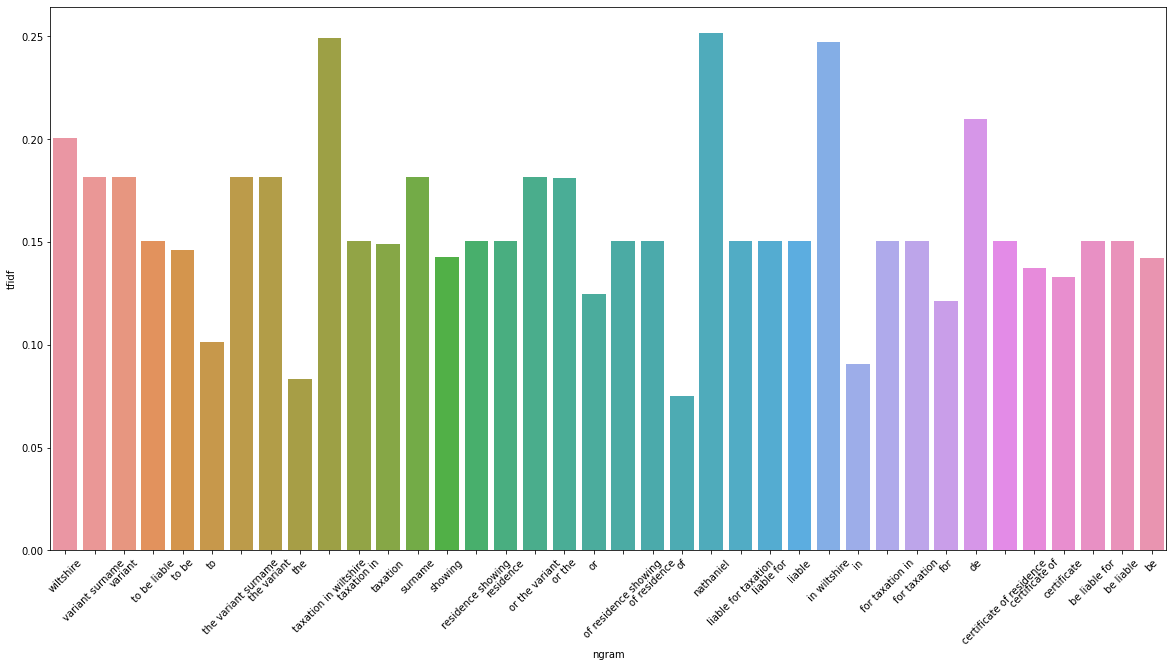

In [0]:
IAID = 'C15544098'
sentence = descriptions[descriptions.IAID == IAID].Description.to_string(index = False)
vec = vectoriser.transform([sentence])
features = vec.nonzero()
feature_names = np.take(vectoriser.get_feature_names(), features[1])
feature_values = vec[features].T
tfidf_data = pd.DataFrame([(x[0],x[1].item()) for x in zip(feature_names, feature_values), columns = ['ngram','tfidf'])

plt.figure(figsize=(20,10))
sns.barplot(data = tfidf_data, x = 'ngram', y = 'tfidf')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45, size = 10)
plt.show()

The graph above shows the tf-idf scores for the ngram features generated from this description. As you can see there are a lot more features than in the previous example, and a lot of them are ngrams rather than just words. This is interesting because it is perhaps surprising that some of these are common enough (e.g. "taxation in Wiltshire") to be in the top 5000 words/ngrams. It is a nice demonstration of tf-idf in action though, with words such as "the" and "of" having much lower scores than rarer words like "nathaniel".

Now we will generate the probability graphs for each ngram. Be warned there will be a lot of graphs! We don't need to examine each one though.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


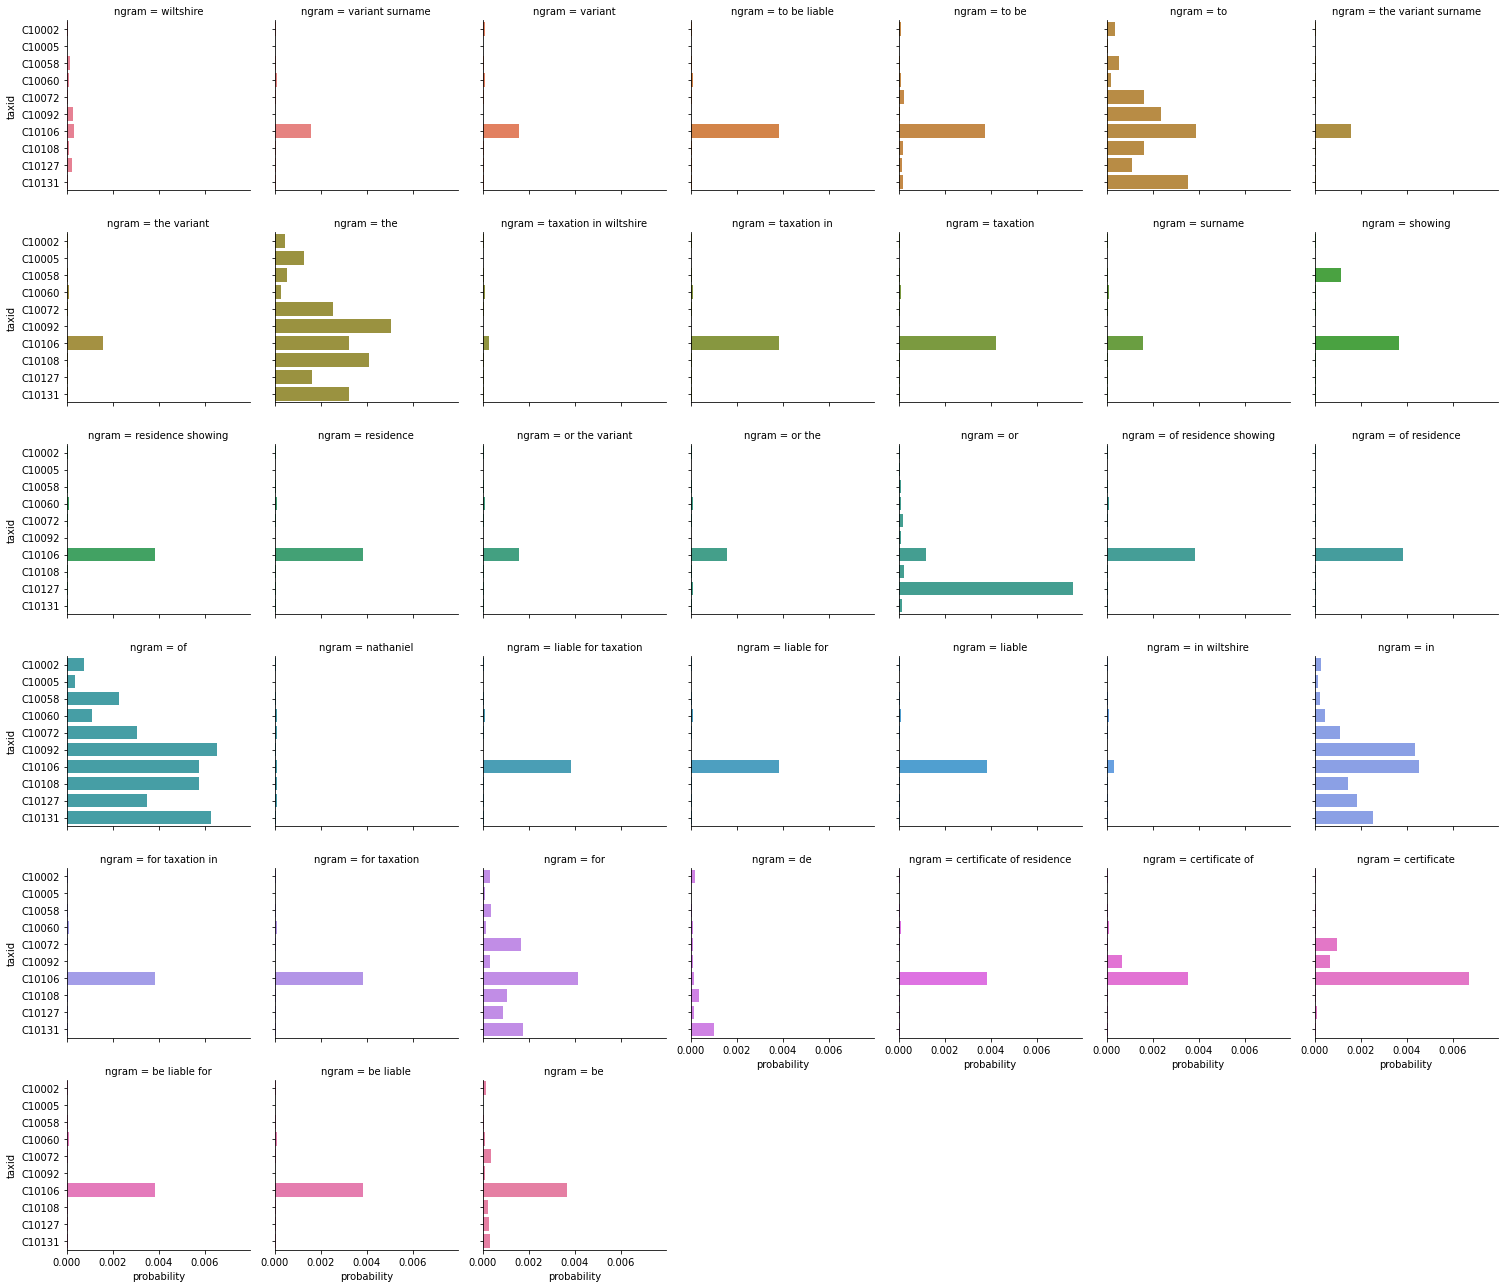

In [0]:
feature_probs = np.exp(nb_model.feature_log_prob_[:,features[1]])
feature_probs.shape
feature_probs = pd.DataFrame(feature_probs.T, columns = nb_model.classes_)
feature_probs['ngram'] = feature_names
feature_probs = feature_probs[feature_probs.ngram.isin(tfidf_data.ngram)]
#feature_probs
feature_probs = feature_probs.melt(['ngram'], var_name='taxid',value_name='probability')
#ordered_probs = feature_probs.ngram.value_counts().index
g = sns.FacetGrid(feature_probs, col = 'ngram', hue = 'ngram', col_wrap=7)
g.map(sns.barplot, 'probability', 'taxid', hue_order = feature_names)
plt.show()

Let's focus on the graph for **"taxation"** - it in in there somewhere.

It should remind you of the graph for "france" from the previous example. It is completely dominated by class 'C10106'. **Why could this be?**

This is the point where we should look at how all of this taxonomy data was created. The taxonomy system is **rules based** and one of the rules states that any description containing the word "taxation" (along with "tax", "taxes" etc.) will be classified as 'C10106'. Similarly any description containing the word 'france' (or 'germany' or 'belgium' etc.) will be classed as 'C10131'. If Naive Bayes didn't add one to all the tf-idf scores then the probability of 'C10106' given the word 'taxation' would always be 100% - no matter what the other words were. If the description was 'france taxation' the model would fall apart as all classes would come out as 0%. Disaster! So adding one to every value allows a 'france taxation' to come out as 50% for each class (roughly).

Now look at some of the other graphs which are dominated by class 'C10106' such as 'variant surname'. These two words aren't related to taxation but if you search for that phrase in Discovery you find that it appears a lot in series 'E115' along with the words 'tax' or 'taxation'. In our training data this phrase and others such as 'certificate of residence' are effectively being identified as strong features of the 'taxation' category. They are then reinforcing the classification. **If we took 'taxation' out of the description we would still get the same result**

Additionally, 'variant', 'variant surname', 'the variant', and 'the variant surname' are all features with high tf-idf weightings and would be classified as 99% (roughly) the same class yet we would not consider them important features for that class. This is an example of where the Naive part of Naive Bayes isn't such a good assumption. 'the variant surname' and 'variant surname' are not independent at all: the existence of the first implies the existence of the second.

**We will discuss these issues in the final session**

#**Conclusion**

This tutorial has highlighted a number of ways of interpreting a machine learning model, and a big flaw in our training process. Here is what we've learned:



*   Bayes rule and how we can combine prior knowledge with evidence
*   How the Naive Bayes algorithm involve simple calculations based on word frequency
*   How an ML algorithm doesn't just give a classification, it can also return a confidence in that result
*   How we can visualise the feature weightings inside the algorithm to understand how it came to its decision
*   Why training data from a rules based system means our ML algorithm can replicate those rules but with unintentional consequences



In the next tutorial we see if we can perform the same analysis of the Support Vector Machine algorithm.